# ANALYZE SALES

In [1]:
# Load all the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
import datetime

In [2]:
transactions = pd.read_csv("datasets/transactions.csv")
customers = pd.read_csv("datasets/customers.csv")
products = pd.read_csv("datasets/products.csv")

In [3]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
id_prod       337016 non-null object
date          337016 non-null object
session_id    337016 non-null object
client_id     337016 non-null object
dtypes: object(4)
memory usage: 10.3+ MB


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
client_id    8623 non-null object
sex          8623 non-null object
birth        8623 non-null int64
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [6]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
id_prod    3287 non-null object
price      3287 non-null float64
categ      3287 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [8]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


## Cleaning all datasets

### Cleaning transactions dataset  
#### Define

- **Some date starting with test must be split**
- **Date variable must be a *datetime* not a string**  
- **We must split id_prod in category and id_prod**
- **We must split session_id in session id and session_category**
- **We must split client_id in client_id and client_category**
- **Turn all the categories variable into a category data type**

#### Code

In [9]:
# Write  a function to split a column
def split_columns(dataset, col):
    ### This function take a dataset and a column of the dataset split the column and the 2 new columns
    new_col_1 = dataset[col].map(lambda x : x.split("_")[1])
    new_col_2 = dataset[col].map(lambda x : x.split("_")[0].upper())
    return new_col_1, new_col_2

In [10]:
# Create a copy of transactions dataset
transactions_clean = transactions.copy()

In [11]:
# Split id_prod in 2 columns,id_prod and category
transactions_clean["id_prod"], transactions_clean["category"] = split_columns(transactions_clean, "id_prod")

In [12]:
# Split client_id columns into 2 columns, client_id and client_category
transactions_clean["client_id"], transactions_clean["client_category"] = split_columns(transactions_clean, "client_id")

In [13]:
# Split session_id in 2 columns, session_id and sesseion_category
transactions_clean["session_id"], transactions_clean["session_category"] = split_columns(transactions_clean, "session_id")

In [14]:
# Check if everything is ok
transactions_clean.head()

,id_prod,date,session_id,client_id,category,client_category,session_category
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S
2,374,2021-09-23 15:13:46.938559,94290,4270,1,C,S
3,2186,2021-10-17 03:27:18.783634,105936,4597,0,C,S
4,1351,2021-07-17 20:34:25.800563,63642,1242,0,C,S


In [15]:
# Check the different categories
transactions_clean.query("category == 'T'")

,id_prod,date,session_id,client_id,category,client_category,session_category
1431,0,test_2021-03-01 02:30:02.237420,0,1,T,CT,S
2365,0,test_2021-03-01 02:30:02.237446,0,1,T,CT,S
2895,0,test_2021-03-01 02:30:02.237414,0,1,T,CT,S
5955,0,test_2021-03-01 02:30:02.237441,0,0,T,CT,S
7283,0,test_2021-03-01 02:30:02.237434,0,1,T,CT,S
13745,0,test_2021-03-01 02:30:02.237443,0,0,T,CT,S
20470,0,test_2021-03-01 02:30:02.237442,0,0,T,CT,S
22347,0,test_2021-03-01 02:30:02.237412,0,1,T,CT,S
26359,0,test_2021-03-01 02:30:02.237439,0,1,T,CT,S
26407,0,test_2021-03-01 02:30:02.237426,0,0,T,CT,S


There are 200 rows which date starts with test. We can guess that it was just to *test* if the system is working or not. These rows are not useful for our analysis. We will remove them.
We can therefore notice that the test day was on 2021-03-01 at 02:30:02 am.

In [16]:
# Remove all the test dates
transactions_clean = transactions_clean.query("category != 'T'")

In [17]:
# Check if there are still test date, no output means there is no test date anymore
assert transactions_clean.category.all() != "T"

In [18]:
transactions_clean.date = transactions_clean.date.astype("datetime64")

In [19]:
# Assert that the date is in the correct type
transactions_clean.date.head()

0   2021-04-10 18:37:28.723910
1   2022-02-03 01:55:53.276402
2   2021-09-23 15:13:46.938559
3   2021-10-17 03:27:18.783634
4   2021-07-17 20:34:25.800563
Name: date, dtype: datetime64[ns]

In [20]:
# turn all the categories variable into a category data type
transactions_clean.iloc[:, 4:] = transactions_clean.iloc[:, 4:].astype("category")

In [21]:
# Check if the variables are categories
transactions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 337015
Data columns (total 7 columns):
id_prod             336816 non-null object
date                336816 non-null datetime64[ns]
session_id          336816 non-null object
client_id           336816 non-null object
category            336816 non-null category
client_category     336816 non-null category
session_category    336816 non-null category
dtypes: category(3), datetime64[ns](1), object(3)
memory usage: 13.8+ MB


In [22]:
# Check the final clean dataset
transactions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 337015
Data columns (total 7 columns):
id_prod             336816 non-null object
date                336816 non-null datetime64[ns]
session_id          336816 non-null object
client_id           336816 non-null object
category            336816 non-null category
client_category     336816 non-null category
session_category    336816 non-null category
dtypes: category(3), datetime64[ns](1), object(3)
memory usage: 13.8+ MB


### Cleaning customers dataset  
#### Define  
- **Split client_id variable into 2 variables**
- **Turn sex variabble in uppercase**
- **Turn sex variable into category data type**

In [23]:
# Make a copy of customers dataset
customers_clean = customers.copy()

In [24]:
# Spllit client_id
customers_clean["client_id"], customers_clean["client_category"] = split_columns(customers_clean, "client_id")

In [25]:
# Turn sex in uppercase
customers_clean.sex = customers_clean.sex.map(lambda x : x.upper())

In [26]:
# Turn sex into category
customers_clean.sex = customers_clean.sex.astype("category")

In [27]:
# Check the final dataset
customers_clean.head()
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 4 columns):
client_id          8623 non-null object
sex                8623 non-null category
birth              8623 non-null int64
client_category    8623 non-null object
dtypes: category(1), int64(1), object(2)
memory usage: 210.7+ KB


### Cleaning products dataset  
#### Define  
- **Categ variable must be category type not an int**
- **Change the categ name to category**  
- **Split the id_prod and keep just the id products**  
- **There is a price of -1, we will remove it**

In [28]:
# Make a copy of the products dataset
products_clean = products.copy()

In [29]:
# Change the categ name to category
products_clean = products_clean.rename(columns={"categ":"category"})

In [30]:
# Split id_prod and keep just the id products using the split_columns function
products_clean["id_prod"], products_clean["category"] = split_columns(products_clean, "id_prod")

In [31]:
# Turn the category into a category type
products_clean.category = products_clean.category.astype("category")

In [32]:
# Check if everything is correct
products_clean.head(2)

,id_prod,price,category
0,1421,19.99,0
1,1368,5.13,0


In [33]:
products_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
id_prod     3287 non-null object
price       3287 non-null float64
category    3287 non-null category
dtypes: category(1), float64(1), object(1)
memory usage: 54.9+ KB


In [34]:
# Check the -1 price row
products_clean.query("price == -1")

,id_prod,price,category
731,0,-1.0,T


This is probably another test, we will remove it for a better analysis.

In [35]:
products_clean = products_clean.query("price != -1")

In [36]:
# Check the description to see if it is ok
products_clean.describe()

,price
count,3286.000000
mean,21.863597
std,29.849786
min,0.620000
25%,6.990000
50%,13.075000
75%,22.990000
max,300.000000


Now that all the datasets are clean we can join them all together in a unique dataset for anaylysis.

In [37]:
# Join all the datasets together
sales_merge = transactions_clean.merge(products_clean, on = ["category", "id_prod"], how = "left")

In [38]:
sales_merge = sales_merge.merge(customers_clean, on = ["client_id", "client_category"], how = "left")

In [39]:
# Turn category and client category into categorical variable
sales_merge.iloc[:, 4:6] = sales_merge.iloc[:, 4:6].astype("category")
# Check if it is ok
sales_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 336815
Data columns (total 10 columns):
id_prod             336816 non-null object
date                336816 non-null datetime64[ns]
session_id          336816 non-null object
client_id           336816 non-null object
category            336816 non-null category
client_category     336816 non-null category
session_category    336816 non-null category
price               336713 non-null float64
sex                 336816 non-null category
birth               336816 non-null int64
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 19.3+ MB


In [40]:
# Check the first rows
sales_merge.head()

,id_prod,date,session_id,client_id,category,client_category,session_category,price,sex,birth
0,1483,2021-04-10 18:37:28.723910,18746,4450,0,C,S,4.99,F,1977
1,226,2022-02-03 01:55:53.276402,159142,277,2,C,S,65.75,F,2000
2,374,2021-09-23 15:13:46.938559,94290,4270,1,C,S,10.71,F,1979
3,2186,2021-10-17 03:27:18.783634,105936,4597,0,C,S,4.20,M,1963
4,1351,2021-07-17 20:34:25.800563,63642,1242,0,C,S,8.99,F,1980


## ANALYZE THE DATA  

Now that all the datasets are cleaned we can make some analysis. 


**What is the average price of the sales?**

In [49]:
sales_merge.describe()

,price,birth
count,336713.000000,336816.000000
mean,17.215189,1977.823396
std,17.855445,13.523923
min,0.620000,1929.000000
25%,8.610000,1971.000000
50%,13.900000,1980.000000
75%,18.990000,1987.000000
max,300.000000,2004.000000


We have an average price of **17.22** but with a standard deviation of **17.85** which means that there are too much variability between the prices. Let's go deep with some plots.  

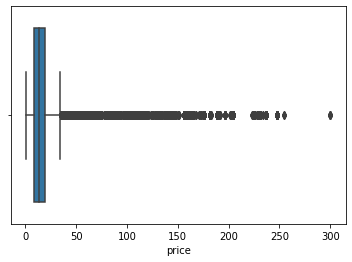

In [47]:
# Boxplot to see the variability
sb.boxplot(sales_merge.price);

Most of the sales are between 0 and 20 and there are very few sales between 50 and 300. 
The average price value of 17.22 is just due to the fact that there are few high sales. Let's confirm that with some calculations.  

In [61]:
print("mean : ",sales_merge.price.mean())
print("mode : ",sales_merge.price.median())
print("median : ",sales_merge.price.mode())

mean :  17.215188513660006
mode :  13.9
median :  0    15.99
dtype: float64


We confirm here that most of the sales are between **0 and 16**, with highest sales at **13.9**

**Which are the categories with more sales?**

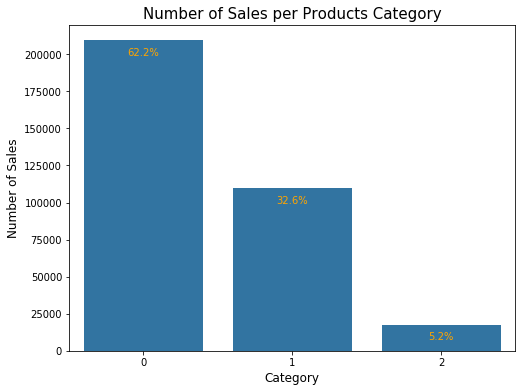

In [117]:
plt.figure(figsize = [8,6])
# Choose a standard color for the plot
base_color = sb.color_palette()[0]
# Barplot of the categories
sb.countplot(data = sales_merge, x = "category", color = base_color)
plt.title("Number of Sales per Products Category", fontsize = 15)
plt.xlabel(xlabel = "Category", fontsize = 12)
plt.ylabel(ylabel = "Number of Sales", fontsize = 12)
# Add some annotations
number_points = sales_merge.shape[0]        # number of points in the dataset
category_counts = sales_merge.category.value_counts() # all Values of the categories
locs, labels = plt.xticks()    # Current tick locations and labels

# Loop through each pair of locations and labels  
for loc, label in zip(locs, labels):
    # Text property for the label to get the current count
    count = category_counts[label.get_text()]
    percentage = '{:0.1f}%'.format(100*count/number_points) # Percentage of each category
    # Put the annotations inside the bar on the top
    plt.text(loc, count-10000, percentage, ha = 'center', color = 'orange')

**62%** of the sales are in category *0*, **33%** in category *1* and just **5.2%** in category *2*. 